a Sanford Health dataset that represents the ED (Emergency Department) volumes presenting to 4 Sanford Health medical centers 1/1/18 through 8/31/2025.
The dataset provides the facility, date, hour, reason, number of total encounters, number of those encounters admitted to a floor.

Forecast the future daily volumes (number of total encounters and the number of encounters admitted to a floor) for the month of September and October CY2025 (where CY means calendar year), by day.

# Basic things

In [12]:
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt

df = pl.read_csv("DSU-Dataset.csv")

In [13]:
df.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,f64,str,i64,i64
"""A""","""2018-01-01""",0.0,"""BREATHING PROBLEM""",1,1
"""A""","""2018-01-01""",0.0,"""BURN""",1,0
"""A""","""2018-01-01""",0.0,"""SHAKING""",1,1
"""A""","""2018-01-01""",0.0,"""VOMITING""",1,0
"""A""","""2018-01-01""",1.0,"""FROSTBITE""",1,0


In [14]:
col = df["Date"].str.to_date()
df = df.with_columns(col)

In [15]:
df.describe()

statistic,Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
str,str,str,f64,str,f64,f64
"""count""","""1174310""","""1174310""",1.17431e6,"""1168105""",1.17431e6,1.17431e6
"""null_count""","""0""","""0""",0.0,"""6205""",0.0,0.0
"""mean""",null,"""2021-12-05 23:13:59.314320""",13.549324,null,1.084646,0.291522
"""std""",null,null,6.142173,null,0.322814,0.47727
"""min""","""A""","""2018-01-01""",0.0,"""ABDOMINAL AORTIC ANEURYSM""",1.0,0.0
"""25%""",null,"""2019-12-23""",10.0,null,1.0,0.0
"""50%""",null,"""2021-12-30""",14.0,null,1.0,0.0
"""75%""",null,"""2023-11-11""",19.0,null,1.0,1.0
"""max""","""D""","""2025-08-31""",23.0,"""WRIST PAIN""",8.0,5.0


The forecasted volumes are not to be broken down by reason of visit.

In [16]:
import numpy as np

columns = df.columns

for col in columns:
    print(f"Column {col} has {df[col].is_null().sum()} missing values.")

print(f"ED Enc has a min of {df['ED Enc'].min()} and a max of {df['ED Enc'].max()} at a particular hour for a certain reason")
print(f"ED Enc Admitted has a min of {df['ED Enc Admitted'].min()} and a max of {df['ED Enc Admitted'].max()} at a particular hour for a certain reason")
print(f"There are sites: {', '.join([site for site in df['Site'].unique()])}")

Column Site has 0 missing values.
Column Date has 0 missing values.
Column Hour has 0 missing values.
Column REASON_VISIT_NAME has 6205 missing values.
Column ED Enc has 0 missing values.
Column ED Enc Admitted has 0 missing values.
ED Enc has a min of 1 and a max of 8 at a particular hour for a certain reason
ED Enc Admitted has a min of 0 and a max of 5 at a particular hour for a certain reason
There are sites: D, B, C, A


# Popularity of visit reasons (for fun)

In [17]:
reason_df = df.group_by("REASON_VISIT_NAME").agg(pl.col("ED Enc").sum().alias("Total ED Enc"), pl.col("ED Enc Admitted").sum().alias("Total ED Enc Admitted"))
reason_df = reason_df.join(df["REASON_VISIT_NAME"].value_counts().rename({"count": "Count of appearances"}), on="REASON_VISIT_NAME")
reason_df = reason_df.with_columns(
    (pl.col("Total ED Enc Admitted") / pl.col("Total ED Enc") * 100).alias("Percentage ED Admitted per Enc"),
)
reason_df = reason_df.sort("Percentage ED Admitted per Enc", descending=True)
reason_df.write_csv("./reasons.csv")

In [18]:
# normalize values

site_dict = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
reason_dict = {reason: idx for idx, reason in enumerate(df['REASON_VISIT_NAME'].unique())}

df_friendly = df.with_columns(
    [pl.col("Date").dt.year().alias("Year").cast(pl.Int32),
     pl.col("Date").dt.month().alias("Month").cast(pl.Int32),
     pl.col("Date").dt.day().alias("Day").cast(pl.Int32),
     pl.col("Date").dt.weekday().alias("Weekday").cast(pl.Int32)]).drop("Date")

df_friendly = df_friendly.select(["Site", "Year", "Month", "Day", "Weekday", "Hour", "REASON_VISIT_NAME", "ED Enc", "ED Enc Admitted"])
df_friendly = df_friendly.with_columns(
    pl.col('Site').replace(site_dict).cast(pl.Int32),
    pl.col('REASON_VISIT_NAME').replace(reason_dict).cast(pl.Int32)
)

df_friendly.head()

Site,Year,Month,Day,Weekday,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted
i32,i32,i32,i32,i32,f64,i32,i64,i64
0,2018,1,1,1,0.0,640,1,1
0,2018,1,1,1,0.0,835,1,0
0,2018,1,1,1,0.0,721,1,1
0,2018,1,1,1,0.0,856,1,0
0,2018,1,1,1,1.0,312,1,0


In [19]:
# Sometimes datetime features are more useful in their original datetime format (like for plotting)
df_friendly_datetime = df.with_columns(
    [pl.col("Date").dt.weekday().alias("Weekday").cast(pl.Int32),
     pl.col("Site").replace(site_dict).cast(pl.Int32),
     pl.col('REASON_VISIT_NAME').replace(reason_dict).cast(pl.Int32)]
)
df_friendly_datetime.head()

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted,Weekday
i32,date,f64,i32,i64,i64,i32
0,2018-01-01,0.0,640,1,1,1
0,2018-01-01,0.0,835,1,0,1
0,2018-01-01,0.0,721,1,1,1
0,2018-01-01,0.0,856,1,0,1
0,2018-01-01,1.0,312,1,0,1


In [20]:
# df_friendly.write_csv("./DSU-Dataset-Feature-Engineering.csv")

# BTW Monday = 0 and Sunday = 6

# Trends in months

Combine encounters by months, then facilities. See trends over months

In [21]:
start_date = df["Date"].min()
end_date = df["Date"].max()
month_date_range = pl.date_range(start=start_date, end=end_date, interval="1mo",  eager=True)

reverse_site_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D'}

monthly_site_data = df_friendly.group_by(["Year", "Month", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
monthly_site_data = monthly_site_data.with_columns(
    monthly_site_data["Site"].replace_strict(reverse_site_dict)
)
print(monthly_site_data.head())

monthly_data = df_friendly.group_by(["Year", "Month"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
print(monthly_data.head())

shape: (5, 5)
┌──────┬───────┬──────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ str  ┆ i64    ┆ i64             │
╞══════╪═══════╪══════╪════════╪═════════════════╡
│ 2021 ┆ 2     ┆ A    ┆ 2930   ┆ 980             │
│ 2019 ┆ 5     ┆ B    ┆ 4929   ┆ 1238            │
│ 2024 ┆ 12    ┆ A    ┆ 4002   ┆ 1307            │
│ 2018 ┆ 11    ┆ B    ┆ 4550   ┆ 1059            │
│ 2024 ┆ 2     ┆ B    ┆ 5190   ┆ 1284            │
└──────┴───────┴──────┴────────┴─────────────────┘
shape: (5, 4)
┌──────┬───────┬────────┬─────────────────┐
│ Year ┆ Month ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i64    ┆ i64             │
╞══════╪═══════╪════════╪═════════════════╡
│ 2021 ┆ 12    ┆ 14405  ┆ 3697            │
│ 2022 ┆ 7     ┆ 15072  ┆ 3839            │
│ 2022 ┆ 9     ┆ 14575  ┆ 3758            │
│ 2019 ┆ 11    ┆ 13083  ┆ 3397            │
│ 2020 ┆ 11    

In [22]:
# monthly_site_data.write_csv("./DSU-Dataset-Monthly-Site-Summary.csv")
# monthly_data.write_csv("./DSU-Dataset-Monthly-Summary.csv")

# Monthly by Site
The next three figures show monthly data by site: the first has both ED Enc and ED Enc Admitted, and the second/third are individual line plots.

In [57]:
daily_site_data = df_friendly.group_by(["Year", "Month", "Day", "Weekday", "Site"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
daily_data = df_friendly.group_by(["Year", "Month", "Weekday", "Day"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())

print(daily_site_data.head())
print(daily_data.head())

shape: (5, 7)
┌──────┬───────┬─────┬─────────┬──────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Day ┆ Weekday ┆ Site ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ --- ┆ ---     ┆ ---  ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i32 ┆ i32     ┆ i32  ┆ i64    ┆ i64             │
╞══════╪═══════╪═════╪═════════╪══════╪════════╪═════════════════╡
│ 2022 ┆ 3     ┆ 27  ┆ 7       ┆ 3    ┆ 83     ┆ 16              │
│ 2021 ┆ 8     ┆ 9   ┆ 1       ┆ 2    ┆ 100    ┆ 25              │
│ 2020 ┆ 4     ┆ 15  ┆ 3       ┆ 2    ┆ 52     ┆ 19              │
│ 2020 ┆ 2     ┆ 10  ┆ 1       ┆ 3    ┆ 96     ┆ 20              │
│ 2021 ┆ 9     ┆ 6   ┆ 1       ┆ 0    ┆ 155    ┆ 39              │
└──────┴───────┴─────┴─────────┴──────┴────────┴─────────────────┘
shape: (5, 6)
┌──────┬───────┬─────────┬─────┬────────┬─────────────────┐
│ Year ┆ Month ┆ Weekday ┆ Day ┆ ED Enc ┆ ED Enc Admitted │
│ ---  ┆ ---   ┆ ---     ┆ --- ┆ ---    ┆ ---             │
│ i32  ┆ i32   ┆ i32     ┆ i32 ┆ i64    ┆ i64          

In [27]:
# monthly_day_site_data.write_csv("./DSU-Dataset-Monthly-Day-Site-Summary.csv")
# monthly_day_data.write_csv("./DSU-Dataset-Monthly-Day-Summary.csv")

# Daily by Site

The next three figures illustrates the data but sums up ED Enc and ED Enc Admitted by day rather than month.

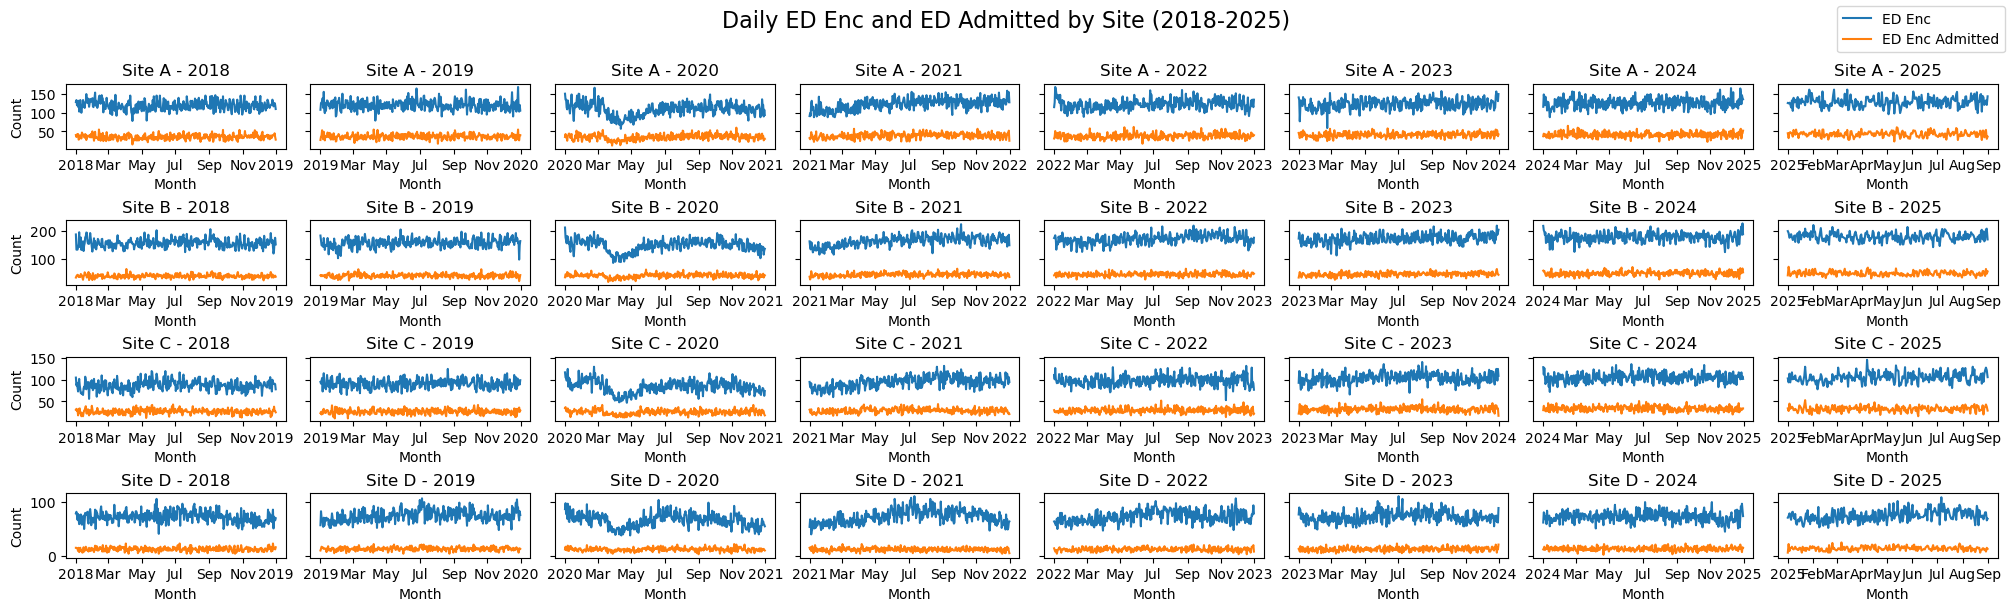

In [72]:
import matplotlib.dates as mdates

# same thing but with days
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

plot_df = daily_site_data.with_columns(
    [pl.col("Site").replace_strict(reverse_site_dict),
     pl.datetime(
            pl.col("Year"),
            pl.col("Month"),
            pl.col("Day")
     ).alias("Date")
    ]
)

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Date').dt.year() == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc', ax=axes[j, i], label="ED Enc" if i == 0 and j == 0 else "", legend=False)
        sns.lineplot(data=plot_df.filter((pl.col('Date').dt.year() == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc Admitted', ax=axes[j, i], label="ED Enc Admitted" if i == 0 and j == 0 else "", legend=False)
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('Count')
        axes[j, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[j, i].xaxis.get_major_locator()))


fig.legend(loc='outside upper right')
fig.suptitle('Daily ED Enc and ED Admitted by Site (2018-2025)', fontsize=16)

plt.show()


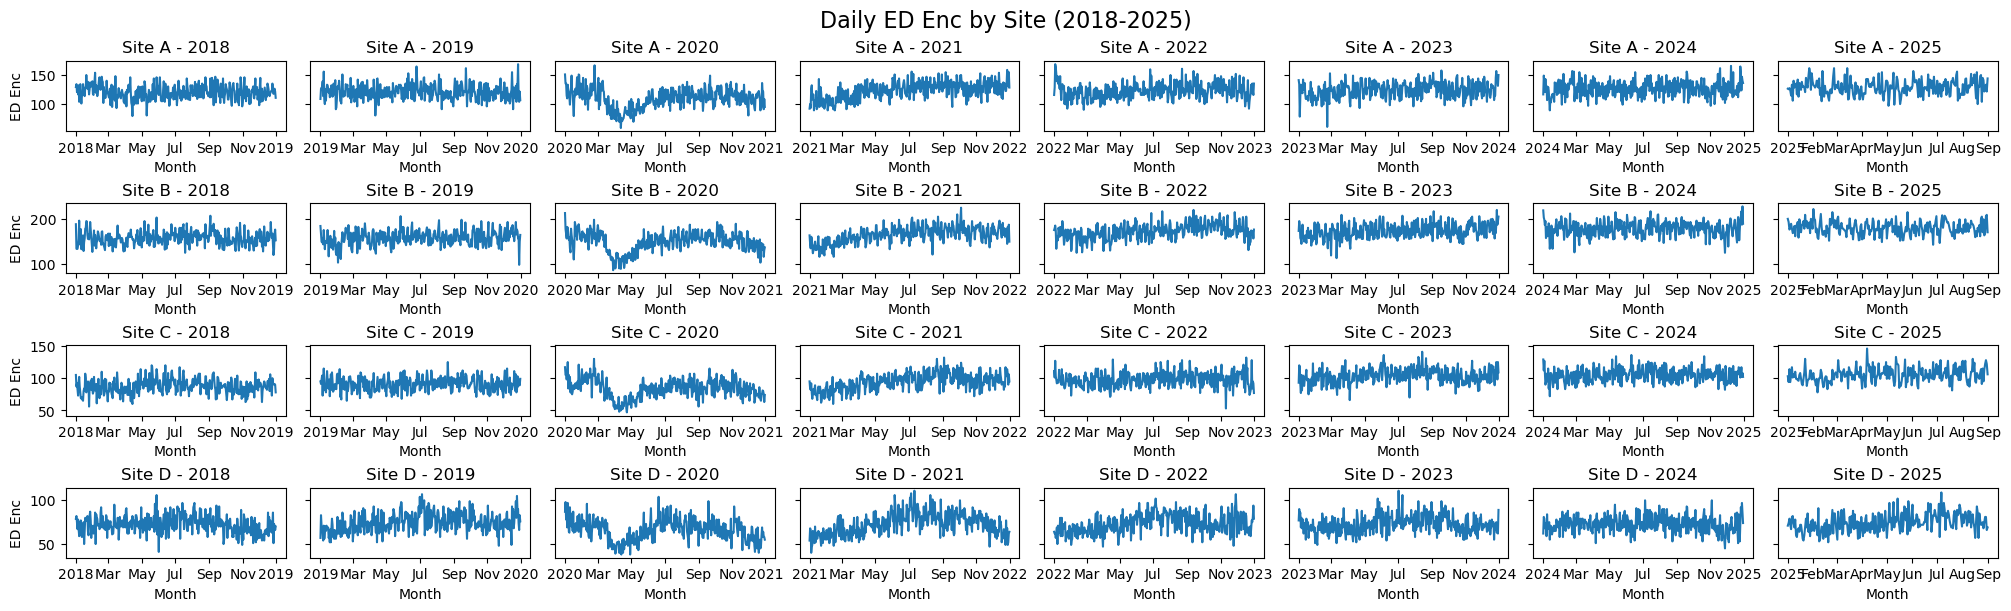

In [74]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc')
        axes[j, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[j, i].xaxis.get_major_locator()))

fig.suptitle('Daily ED Enc by Site (2018-2025)', fontsize=16)

plt.show()


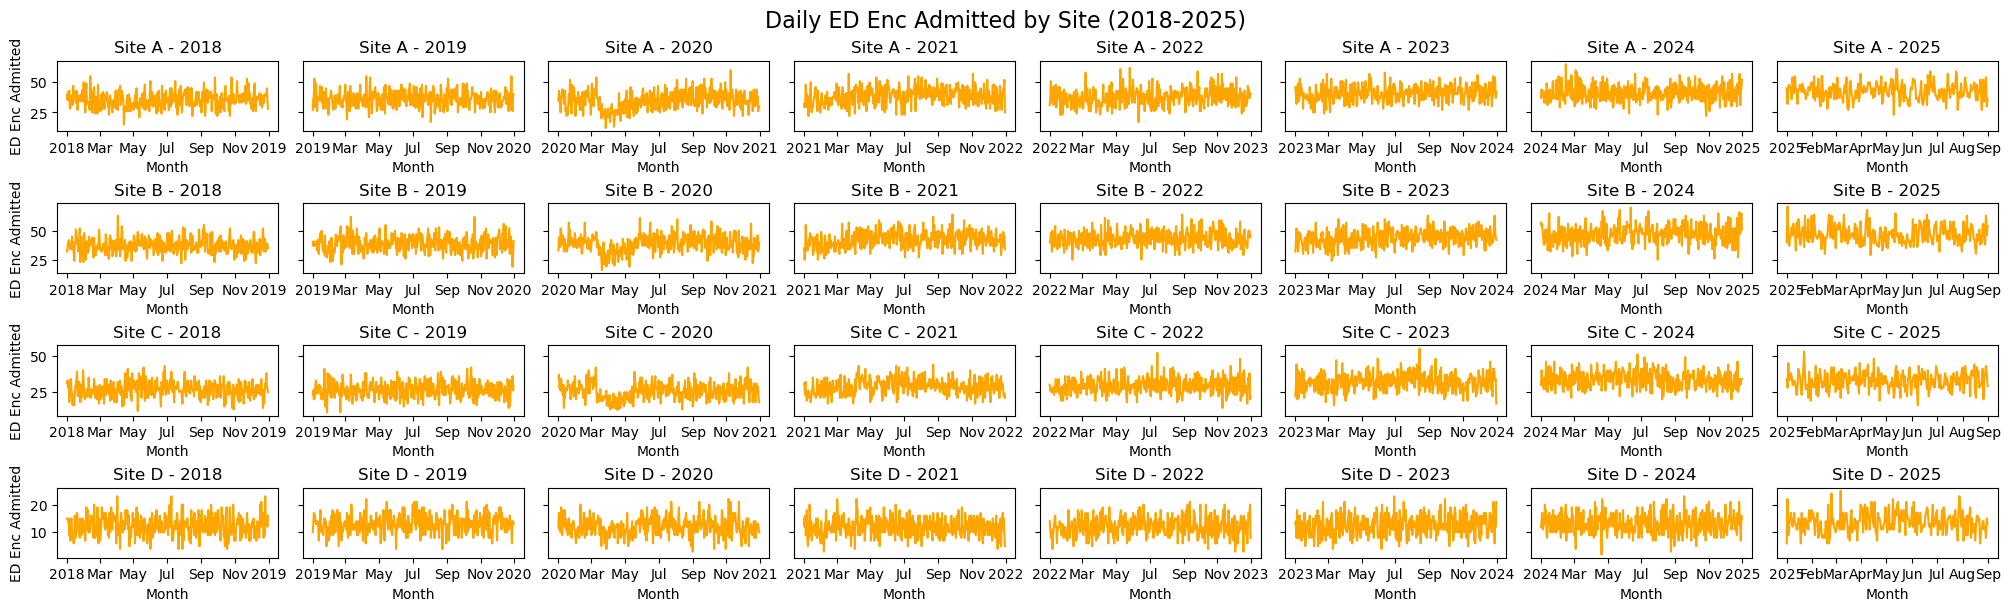

In [75]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Date', y='ED Enc Admitted', ax=axes[j, i], color='orange')
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc Admitted')
        axes[j, i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[j, i].xaxis.get_major_locator()))

fig.suptitle('Daily ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


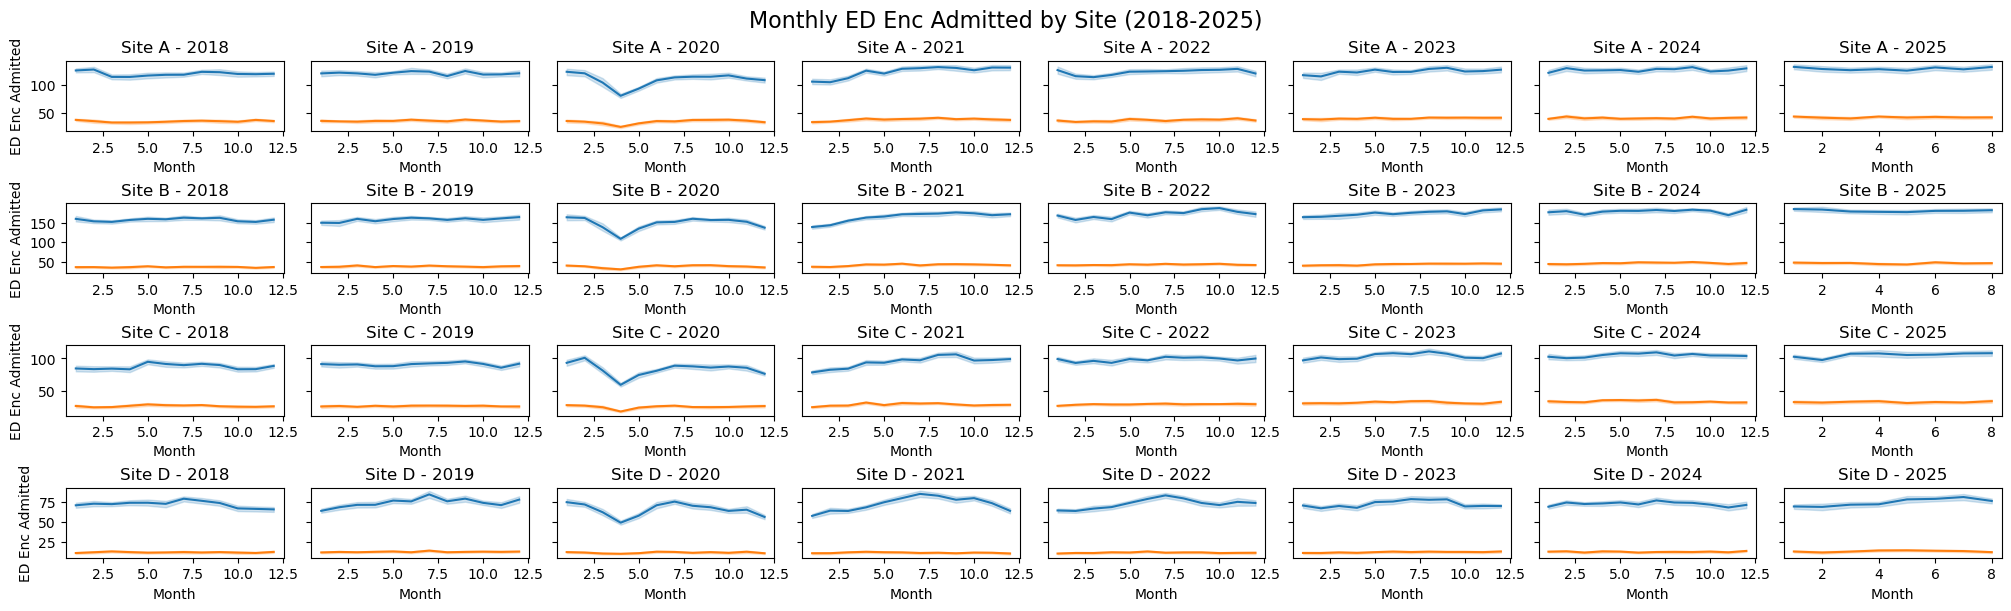

In [81]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i])
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc Admitted', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc Admitted')

fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


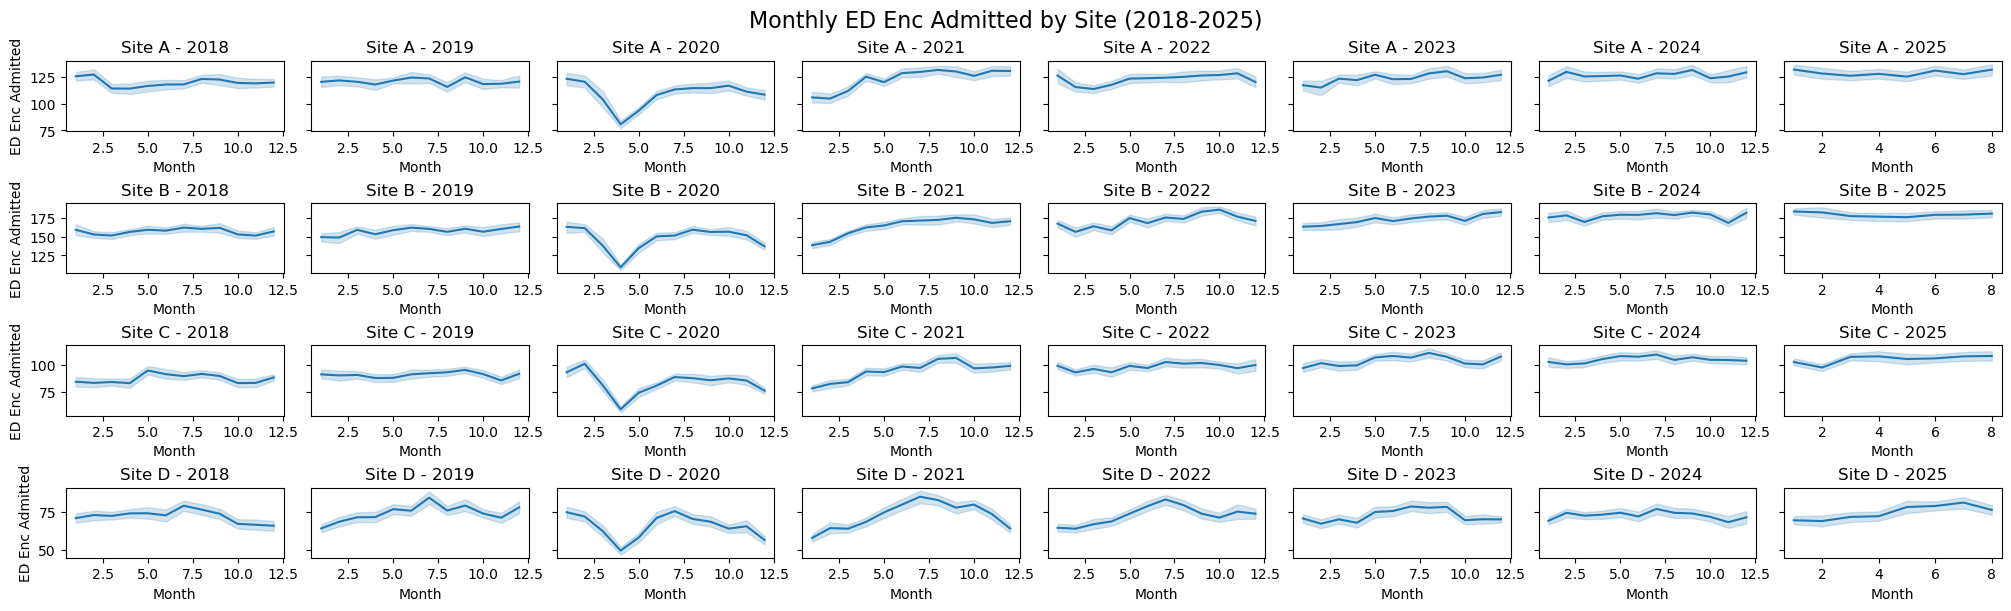

In [82]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc', ax=axes[j, i])
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc Admitted')

fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


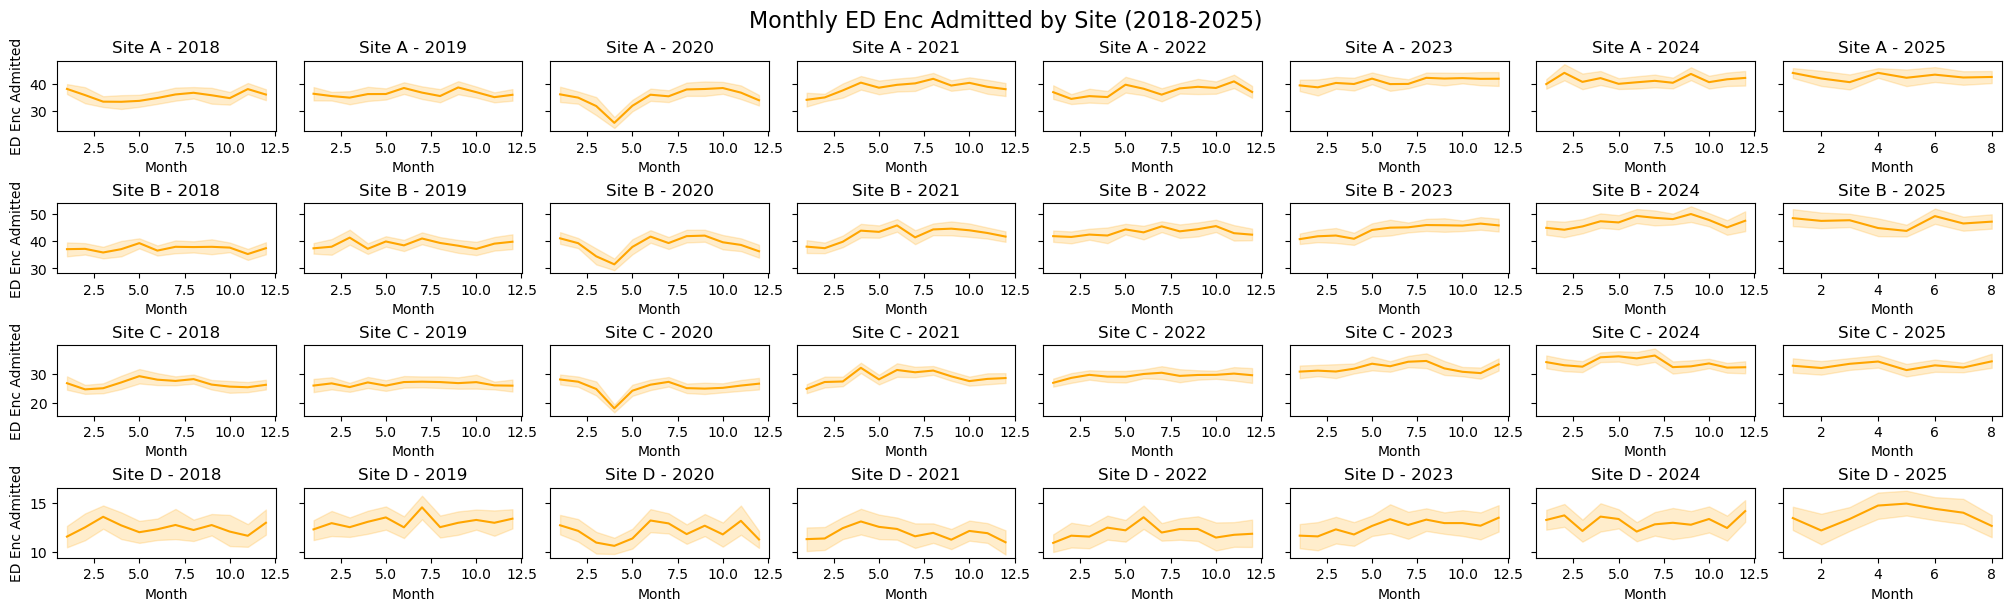

In [83]:
fig, axes = plt.subplots(4, 8, layout="constrained", figsize=(20, 6), sharex=False, sharey="row")

for i, year in enumerate(range(2018, 2026)):
    for j, site in enumerate(['A', 'B', 'C', 'D']):
        sns.lineplot(data=plot_df.filter((pl.col('Year') == year) & (pl.col('Site') == site)),
                     x='Month', y='ED Enc Admitted', ax=axes[j, i], color='orange')
        axes[j, i].set_title(f'Site {site} - {year}')
        axes[j, i].set_xlabel('Month')
        axes[j, i].set_ylabel('ED Enc Admitted')

fig.suptitle('Monthly ED Enc Admitted by Site (2018-2025)', fontsize=16)

plt.show()


# Overall graphs
Again, the next three figures illustrate overall sums of ED Enc and ED Enc Admitted.

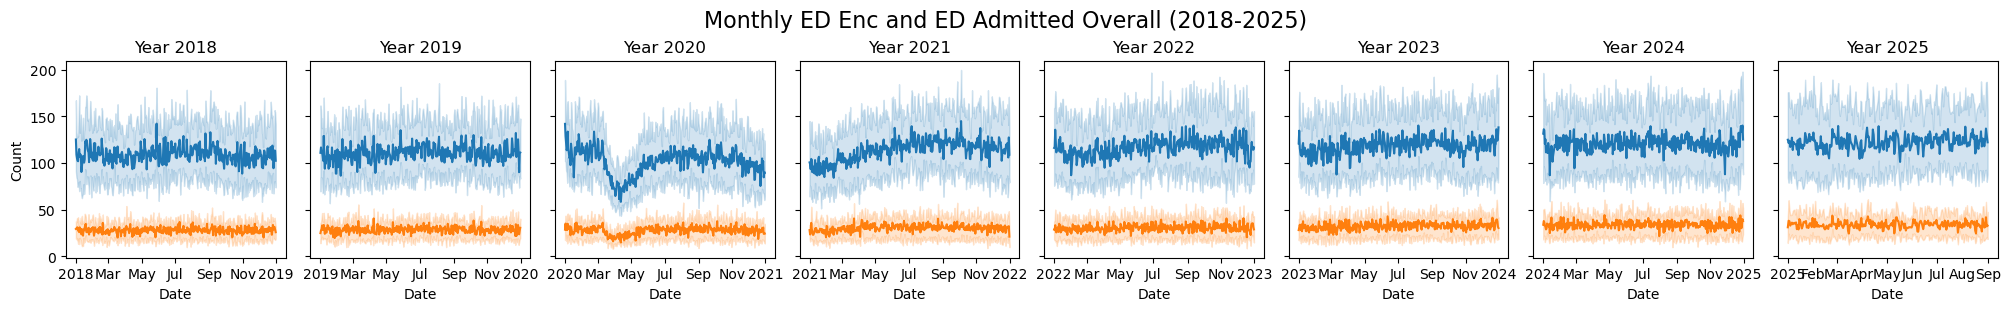

In [ ]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Date', y='ED Enc Admitted', ax=axes[i], label="ED Enc Admitted" if i == 0 else "", legend=False)
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Count')
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i].xaxis.get_major_locator()))

fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Date', y='ED Enc', ax=axes[i], label="ED Enc" if i == 0 else "", legend=False)
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Count')
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i].xaxis.get_major_locator()))

fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

In [ ]:
fig, axes = plt.subplots(1, 8, layout="constrained", figsize=(20, 3), sharex=False, sharey=True)

for i, year in enumerate(range(2018, 2026)):
    sns.lineplot(data=plot_df.filter(pl.col('Year') == year),
                    x='Date', y='ED Enc Admitted', ax=axes[i], label="ED Enc" if i == 0 else "", legend=False)
    axes[i].set_title(f'Year {year}')
    axes[i].set_xlabel('Date')
    axes[i].set_ylabel('Count')
    axes[i].xaxis.set_major_formatter(mdates.ConciseDateFormatter(axes[i].xaxis.get_major_locator()))

fig.suptitle("Monthly ED Enc and ED Admitted Overall (2018-2025)", fontsize=16)
plt.show()

# Hourly blocks
We also want to predict within 6 hour blocks (0-5, 6-11, 12-17, 18-23).

In [37]:
df_friendly_datetime

Site,Date,Hour,REASON_VISIT_NAME,ED Enc,ED Enc Admitted,Weekday
i32,date,f64,i32,i64,i64,i32
0,2018-01-01,0.0,640,1,1,1
0,2018-01-01,0.0,835,1,0,1
0,2018-01-01,0.0,721,1,1,1
0,2018-01-01,0.0,856,1,0,1
0,2018-01-01,1.0,312,1,0,1
…,…,…,…,…,…,…
3,2025-08-31,22.0,370,1,0,7
3,2025-08-31,23.0,358,1,0,7
3,2025-08-31,23.0,241,1,0,7


We will define each hourly block as a sort of enum (but really it's a dict)

In [52]:
block_ranges = { 1: range(0, 6),
                 2: range(6, 12),
                 3: range(12, 18),
                 4: range(18, 24) }

hourly_blocks_data = df_friendly_datetime.with_columns(
    pl.col("Hour").map_elements(lambda hr: next(block for block, hrs in block_ranges.items() if hr in hrs)).alias("Hour")
)
hourly_blocks_data = hourly_blocks_data.group_by(["Site", "Date", "Hour"]).agg(pl.col("ED Enc").sum(), pl.col("ED Enc Admitted").sum())
hourly_blocks_data = hourly_blocks_data.sort(["Site", "Date", "Hour"])
hourly_blocks_data = hourly_blocks_data.with_columns(
    pl.col("Site").replace_strict(reverse_site_dict)
)

hourly_blocks_data.head()

Site,Date,Hour,ED Enc,ED Enc Admitted
str,date,i64,i64,i64
"""A""",2018-01-01,1,16,6
"""A""",2018-01-01,2,25,8
"""A""",2018-01-01,3,52,16
"""A""",2018-01-01,4,36,10
"""A""",2018-01-02,1,18,5


In [53]:
hourly_blocks_data.write_csv("./DSU-Dataset-Hourly-Blocks-Summary.csv")

# Heatmap with feature engineering and without COVID years
New features include weekday

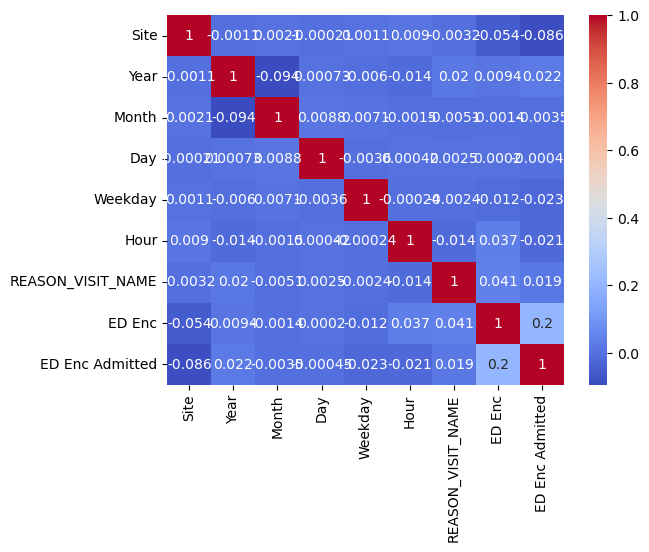

In [34]:
df_friendly_normal = df_friendly.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))

ax = sns.heatmap(df_friendly_normal.corr(), annot=True, cmap='coolwarm', xticklabels=df_friendly_normal.columns, yticklabels=df_friendly_normal.columns)

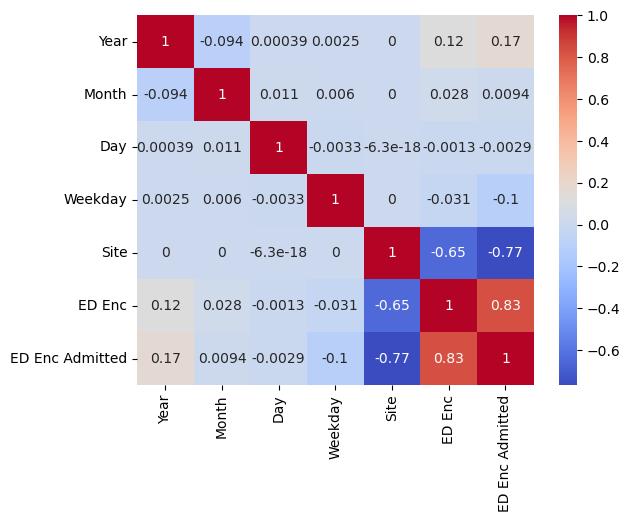

In [35]:
daily_site_data_normal = daily_site_data.filter((pl.col('Year') != 2020) & (pl.col('Year') != 2021))

ax = sns.heatmap(daily_site_data_normal.corr(), annot=True, cmap='coolwarm', xticklabels=daily_site_data_normal.columns, yticklabels=daily_site_data_normal.columns)